# Анализ и подготовка плана действий по удержанию клиентов в сети фитнес-центров

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал.

**Задача:** провести анализ и подготовить план действий по удержанию клиентов.

## Обзор и предобработка данных

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Преобразуем данные в датасет

data = pd.read_csv('/datasets/gym_churn.csv')
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Таблица с данными включает в себя 14 столбцов и 4000 строк. Встречающиеся типы данных - целые числа (int) и вещественные числа (float).

Количество строк в каждом столбце одинаково, в данных нет пропусков. Каждому столбцу соответствует нужный тип данных, кроме Month_to_end_contract - это столбец с информацией о количестве месяцев (необходимо преобразование в целое число). Также для удобства анализа следует привести названия столбцов к нижнему регистру.

In [4]:
# Приведем названия столбцов к нижнему регистру

data.columns = data.columns.str.lower()
data.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

In [5]:
# Изменим тип данных столбца `month_to_end_contract` на int

data['month_to_end_contract'] = data['month_to_end_contract'].astype('int')

In [6]:
data.info() # Проверка

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   int64  
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

In [7]:
# Проверим наличие пропусков в данных

data.isna().sum()

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

In [8]:
# Проверим наличие дубликатов в данных

print('Дубликатов в данных обнаружено:', data.duplicated().sum())

Дубликатов в данных обнаружено: 0


## Исследовательский анализ данных (EDA)

In [9]:
data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


- В столбце `gender` представлены данные о поле клиента (0 или 1 обозначают пол). Среднее значение очень близко к 0,5, а медиана равна 1, следовательно, мужчин и женщин в выборке примерно поровну.


- В столбце `near_location` представлены данные о клиентах, которые проживают или работают рядом с фитнес-центром (обозначаются так же 0 и 1). Среднее - 0,85, медиана - 1, значит, большинство клиентов живут рядом.


- В столбце `partner` представлены данные о людях, которые являются или не являются сотрудниками компании-партнёра клуба, обозначаются 0 и 1. При этом в выборке примерно в равной пропорции представлены обе группы (среднее близко к 0,5).


- В столбце `promo_friends` представлены данные о людях, которые приобрели или не приобрели первый абонемент по акции "Приведи друга". Категории обозначаются 0 и 1. При этом в выборке больше тех, кто пришёл без данной акции (среднее близко к 0,3, а медиана равна 0).


- В столбце `phone` представлены данные о клиентах, у которых есть в базе номер контактного телефона (значение 1) или нет (значение 0). У большинства клиентов номер имеется (среднее около 0,9, первый квартиль - единица).


- В столбце `avg_class_frequency_total` представлены данные о средней частоте посещений фитнес-центра клиентами за все время с начала действия абонемента от 0 до 6 раз в неделю. В среднем это значение составляет около 2 раз в неделю. Выборка равномерная, так как среднее почти равно медиане, а стандартное отклонение незначительно. Данные по столбцу `avg_class_frequency_current_month` (частота посещений фитнес-клуба клиентами в неделю за месяц) примерно такие же.


- В столбце `avg_additional_charges_total` указана суммарная выручка от всех прочих услуг фитнес-центра. Она варъируется от 0,15 до 552,6 денежных единиц. В среднем значение выручки составляет 147 денежных единиц. Разброс данных довольно большой. Кто-то покупает доп. услуги фитнес-центра, а кто-то нет.


- В столбце `churn` содержится информация об оттоке клиентов в текущем месяце. 0 - те, кто продолжает пользоваться услугами, 1 - те, кто ушел. Судя по выборке, услугами продолжает пользоваться большая часть клиентов (среднее - 0,27, медиана равна 0).

Некоторые столбцы рассмотрим отдельно:

In [10]:
print(data['age'].describe())
print('--------------------------')
print(data['age'].sort_values().unique())

count    4000.000000
mean       29.184250
std         3.258367
min        18.000000
25%        27.000000
50%        29.000000
75%        31.000000
max        41.000000
Name: age, dtype: float64
--------------------------
[18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 41]


- В выборке имеются данные о клиентах в возрасте от 18 лет до 41 года. Средний возраст клиента - 29 лет. При этом в выборке присутствует примерно одинаковое количество клиентов каждого возраста (среднее близко к медиане, стандартное отклонение довольно малое). Нет клиентов в возрасте 40 лет.

In [11]:
print(data['lifetime'].describe())
print('--------------------------')
print(data['lifetime'].sort_values().unique())

count    4000.000000
mean        3.724750
std         3.749267
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max        31.000000
Name: lifetime, dtype: float64
--------------------------
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 26 27 29 31]


- Здесь представлены данные о клиентах, которые обращались в фитнес-центр впервые от 0 до 31 месяца назад (при этом нет клиентов, у которых прошло 25, 28 или 30 месяцев с момента первого обращения). Среднее время с момента первого обращения составляет почти 4 месяца.

In [12]:
print(data['contract_period'].describe())
print('--------------------------')
print(data['contract_period'].sort_values().unique())

count    4000.000000
mean        4.681250
std         4.549706
min         1.000000
25%         1.000000
50%         1.000000
75%         6.000000
max        12.000000
Name: contract_period, dtype: float64
--------------------------
[ 1  6 12]


- В выборке представлены данные о контрактах клиентов длиной в 1, 6 и 12 месяцев. Средняя длительность действующего абонемента составляет 4-5 месяцев. При этом есть перекос в данных: для большинства срок действующего абонемента равен 1 месяцу.

In [13]:
print(data['month_to_end_contract'].describe())
print('--------------------------')
print(data['month_to_end_contract'].sort_values().unique())

count    4000.000000
mean        4.322750
std         4.191297
min         1.000000
25%         1.000000
50%         1.000000
75%         6.000000
max        12.000000
Name: month_to_end_contract, dtype: float64
--------------------------
[ 1  2  3  4  5  6  7  8  9 10 11 12]


В этом столбце представлены данные по клиентам, до окончания абонементов которых осталось от 1 до 12 месяцев. В среднем это значение составляет около 4 месяцев. При этом больше половины всей выборки - это клиенты, до конца абонементов которых остался 1 месяц.

### Анализ средних значений признаков

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался:

In [14]:
data.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


*Чем среднее значение по показателям ближе к 1, тем больше число клиентов с признаком.* 

**0 - клиент лоялен; 1 - клиент ушел.**


- Пол: примерно равное количество клиентов разного пола в группах.


- Близость к фитнес-центру: в группе, которая лояльна к фитнес-центру, чуть больше человек, которые живут или работают поблизости.


- Есть различия в оттоке между теми, кто является обладателем скидки на абонемент клуба. Среди тех, кто остался в клубе - примерно пополам и тех, кто связан с партнёрами, и тех, кто не связан. Но из тех клиентов, кто ушёл в отток, больше людей, не связанных с компанией-партнёром.


- В обеих группах больше людей, которые приобрели первый абонемент не по промо-акции "Приведи друга". Но среди тех, кто остался, пришедших по промо-акции больше.


- Практически все клиенты оставляют контакты для связи.


- Длительность действующего абонемента по оставшимся пользователям в среднем около 5-6 месяцев, а по ушедшим - 1-2 месяца. Это говорит о том, что купившие длительный абонемент с большей неохотой уйдут в отток, чем те, у кого абонемент действует в течение короткого срока.


- Посещение групповых занятий по выделенным группам также отличается: среди лояльных клиентов распределение по посещению групповых занятий примерно равномерно (посещающих чуть меньше). Но среди тех, кто ушёл в отток, не посещающих групповые занятия значительно больше, чем посещающих.


- В группе лояльных фитнес-центру клиентов средний возраст составляет около 30 лет, а среди уходящих - около 27 лет.


- Средняя выручка от других услуг фитнес-центра между группами разнится на 43 ден.ед. (в группе лояльных она выше, чем в группе уходящих).


- В среднем срок до окончания действующего абонемента у клиентов, ушедших в отток, около 1-2 месяцев, а у оставшихся клиентов - около 5 месяцев. Это снова указывает на то, что уходят в большей степени те, у кого длительность оставшегося абонемента невысока.


- Время с момента первого обращения для уходящих в отток равно 1 месяцу, а для тех, кто остался, близко к 5 месяцам. Таким образом, клиенты, которые лояльны в первые месяцы, скорее всего, не уйдут в отток после длительного периода пользования услугами фитнес-центра.


- Средняя частота посещений в неделю за время действия абонемента в группах не сильно отличается. Лояльные клиенты в среднем посещают центр 2 раза в неделю, а ушедшие - от 1 до 2.


- Разница между группами в средней частоте посещений в неделю за месяц также не сильно высока: лояльные клиенты в среднем посещали фитнес-клуб 2 раза в неделю, а ушедшие в отток - 1 раз в неделю.

### Анализ распределения признаков

Перед началом анализа разделим данные на две группы: лояльных и ушедших клиентов:

In [15]:
churn_data = data.query('churn == 1')
loyal_data = data.query('churn == 0')

Построим столбчатые гистограммы и графики распределения признаков для обеих групп :

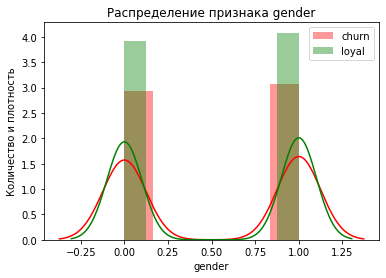

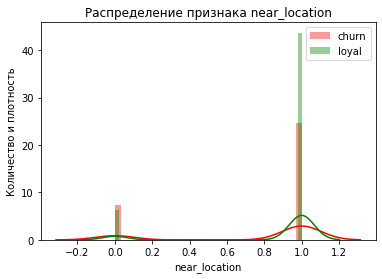

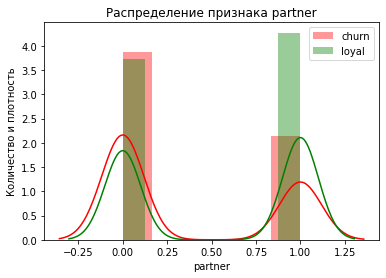

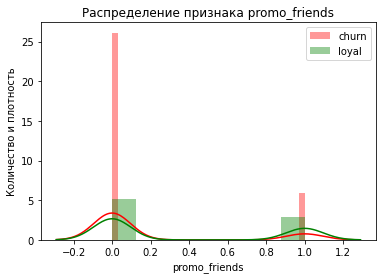

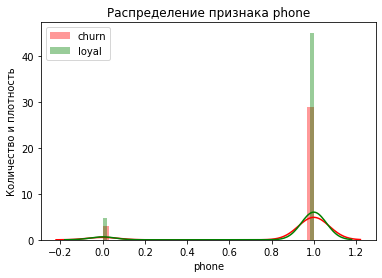

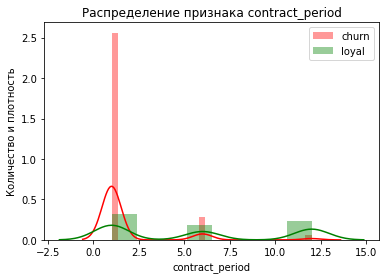

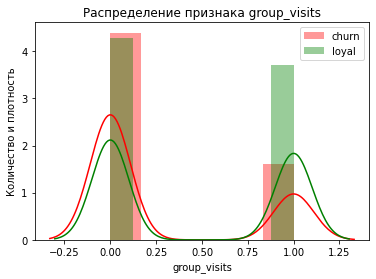

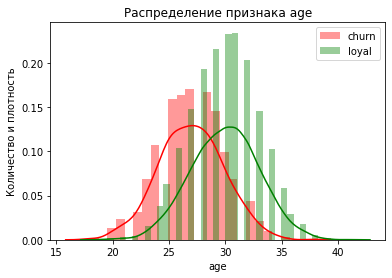

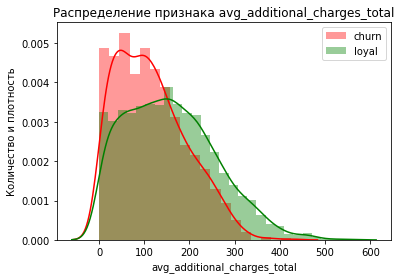

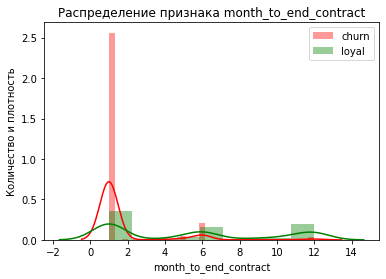

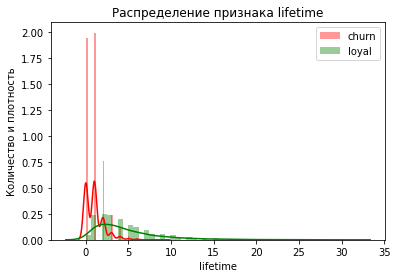

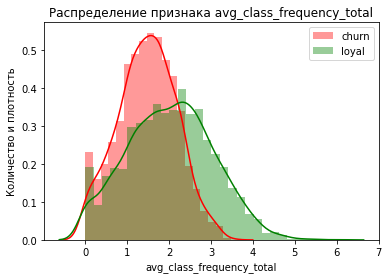

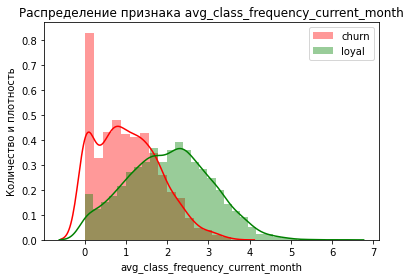

In [16]:
fig, ax = plt.subplots()
for column in data.drop('churn', axis = 1).columns:
    plt.title("Распределение признака "+column)
    plt.xlabel(column)
    plt.ylabel("Количество и плотность")
    sns.distplot(churn_data[column], label='churn', color='red')
    sns.distplot(loyal_data[column], label='loyal', color='green')
    plt.legend()
    plt.show()

- По полу, близости к фитнес-центру, наличию контактного телефона обе группы имеют схожее равномерное распределение.


- Есть различия в распределении групп между теми, кто является сотрудником компании-партнёра клуба и не является. В группе лояльных клиентов число имеющих отношение к компании-партнёра сотрудников явно больше, чем среди тех, кто уходит в отток. Различия в распределении групп по посещению групповых занятий такие же, как и в распределениях по принадлежности к компании-партнёру.


- Среди тех, кто остался, по промо-акции "Приведи друга" клиентов немного больше, но распределения схожи.


- Распределение длительности действующего абонемента по оставшимся пользователям и ушедшим различается. Лояльных клиентов, приобретающих абонемент на 1 месяц больше всего, меньше их сроком на год, и наименьшее количество клиентов - на 6 месяцев. А для ушедших в отток 1 месяц - самый популярный, затем - 6 месяцев (с очень низким числом абонементов), и практически нет абонементов на 12 месяцев. Различия в распределении групп по сроку до окончания действующего абонемента такие же, как и в распределениях по длительности абонемента.


- По среднему возрасту обе группы имеют нормальное распределение, но датасет лояльных клиентов немного смещён вправо, а датасет ушедших клиентов - влево.


- Распределение средней выручки от других услуг фитнес-центра для обоих датасетов смещено влево с большим смещением для ушедших людей. То есть те, кто уходит, практически ничего не тратят на дополнительные услуги в фитнес-центре.


- Распределение времени с момента первого обращения для обоих групп похоже на распределение Пуассона. Но для ушедших в отток клиентов оно сильно смещено влево, практически не имея значения в более высоких значениях, а для лояльных клиентов принимает более высокие значения.


- Распределение для средней частоты посещений в неделю за время действия абонемента в обоих группах является нормальным. Для лояльной группы оно немного смещено влево, а для группы уходящих в отток имеется сильное смещение влево. Аналогичные различия между группами наблюдаются и для распределений средней частоты посещений в неделю за месяц.

### Построение матрицы корреляций

In [17]:
corr = data.corr()
corr = corr.round(2)
corr

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.00,0.01,-0.01,-0.01,-0.01,0.00,0.02,0.01,-0.01,-0.00,0.01,0.01,0.01,0.00
near_location,0.01,1.00,-0.01,0.21,-0.02,0.15,0.15,0.06,0.04,0.14,0.07,0.04,0.06,-0.13
partner,-0.01,-0.01,1.00,0.45,0.01,0.31,0.02,0.05,0.02,0.29,0.06,0.02,0.05,-0.16
promo_friends,-0.01,0.21,0.45,1.00,0.00,0.24,0.12,0.05,0.04,0.24,0.07,0.03,0.05,-0.16
phone,-0.01,-0.02,0.01,0.00,1.00,-0.01,-0.01,-0.01,0.01,-0.01,-0.02,0.01,0.01,-0.00
contract_period,0.00,0.15,0.31,0.24,-0.01,1.00,0.17,0.14,0.11,0.97,0.17,0.10,0.16,-0.39
group_visits,0.02,0.15,0.02,0.12,-0.01,0.17,1.00,0.08,0.03,0.16,0.08,0.06,0.08,-0.18
age,0.01,0.06,0.05,0.05,-0.01,0.14,0.08,1.00,0.08,0.13,0.16,0.12,0.18,-0.40
avg_additional_charges_total,-0.01,0.04,0.02,0.04,0.01,0.11,0.03,0.08,1.00,0.11,0.08,0.04,0.08,-0.20
month_to_end_contract,-0.00,0.14,0.29,0.24,-0.01,0.97,0.16,0.13,0.11,1.00,0.16,0.09,0.15,-0.38


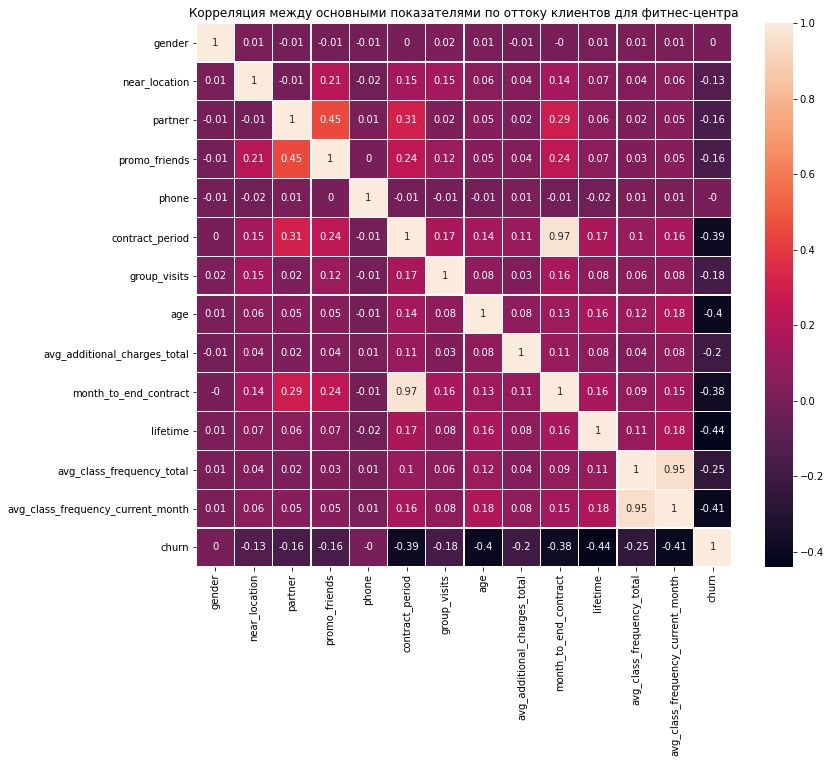

In [18]:
# Строим хитмэп

fig, ax = plt.subplots(figsize=(12,10))
plt.title("Корреляция между основными показателями по оттоку клиентов для фитнес-центра")
sns.heatmap(corr, linewidths=.2, annot=True, ax=ax)
ax.set_ylim(14, 0);

По матрице корреляций мы видим, что пол и наличие контактного телефона не влияют на конечный показатель оттока (0). Все остальные показатели имеют обратное влияние: слабое, либо чуть более сильное. Явно влияющих признаков, сильно связанных с результирующим показателем, не заметно.

Также можно заметить, что имеется сильная связь между показателями длительности абонемента и количеством месяцев до конца абонемента. Это говорит о том, что в выборке представлены клиенты, которые отобраны на определённом этапе покупки абонемента. Скорее всего, в самом начале действия абонемента. Также наблюдается сильная связь между средней частотой посещений в неделю с начала пользования услугами и за предыдущий месяц. Это говорит о другой зависимости: скорее всего, клиенты посещают фитнес-центр примерно одинаковое число раз в неделю вне зависимости от того, сколько они пользуются услугами центра.

## Модель прогнозирования оттока клиентов

### Обучение модели

In [19]:
# Разделим данные на признаки и целевую переменную

X = data.drop('churn', axis = 1)
y = data['churn']

# Разделим выборку на обучающую и валидационную в соотношении 80:20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Cтандартизируем данные

scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

Далее обучим модель на train-выборке двумя способами: логистической регрессией и методом случайного леса.

**Логистическая регрессия**

In [20]:
# Зададим алгоритм для модели

lr_model = LogisticRegression(random_state=0)

# Обучим модель

lr_model.fit(X_train_st, y_train)

# Воспользуемся обученной моделью, чтобы сделать прогнозы

lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:0,1]

**Случайный лес**

In [21]:
# Зададим алгоритм для модели

rf_model = RandomForestClassifier(random_state=0)

# Обучим модель

rf_model.fit(X_train_st, y_train)

# Воспользуемся обученной моделью, чтобы сделать прогнозы

rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:0,1]

### Оценка метрик и выбор лучшей модели

Создадим функцию для вывода метрик: **accuracy** (доля правильных ответов), **precision** (точность) и **recall** (полнота).

In [22]:
# Напишем функцию, которая будет выводить метрики на экран

def metrics(y_true, y_pred, y_proba, model_name):
    print("Метрики для модели "+model_name+':')
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [23]:
# Рассчитаем метрики для обеих моделей

metrics(y_test, lr_predictions, lr_probabilities, 'логистической регрессии')       
print()
metrics(y_test, rf_predictions, rf_probabilities, 'случайного леса')

Метрики для модели логистической регрессии:
	Accuracy: 0.94
	Precision: 0.90
	Recall: 0.85

Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.88
	Recall: 0.83


Обе модели достаточно хорошо способны делать прогноз (метрики близки к единице). Однако, модель логистической регрессии выигрывает, т.к. она лучше модели случайного леса по всем показателям.

## Кластеризация клиентов

### Стандартизация данных

Перед кластеризацией пользователей необходимо провести стандартизацию данных:

In [24]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

### Построение матрицы расстояний и дендрограммы

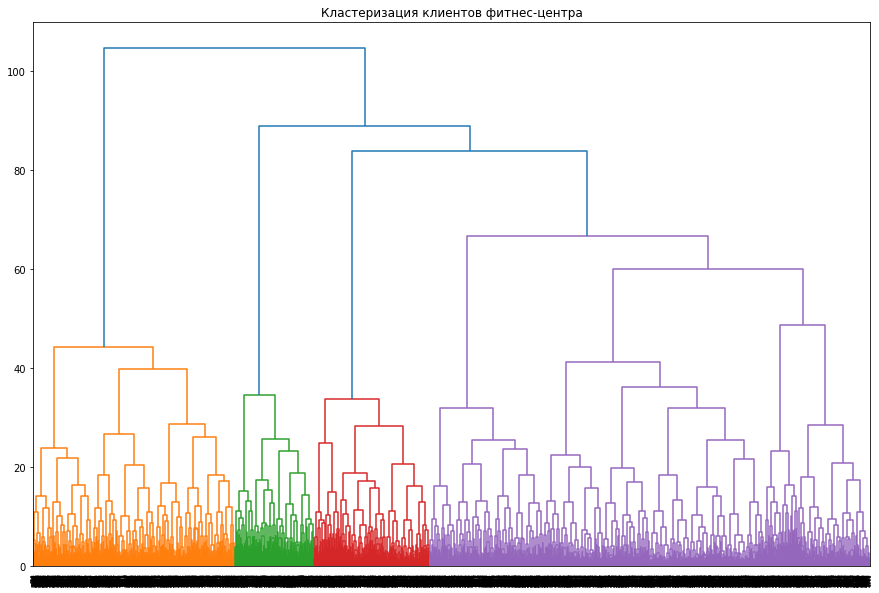

In [25]:
# Строим матрицу расстояний

linked = linkage(X_sc, method = 'ward')

# Строим дендрограмму

plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Кластеризация клиентов фитнес-центра')
plt.show()

На основании полученного графика предполагается, что в данных можно выделить **4 кластера**.

### Обучение модели кластеризации и прогноз кластеров клиентов

Для прогноза кластеров клиентов принято решение взять число кластеров `n=5`. Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов:

In [26]:
# Зададим модель KMeans с числом кластеров 5

km = KMeans(n_clusters = 5, random_state=0)

# Спрогнозируем кластеры для наблюдений

labels = km.fit_predict(X_sc)

# Сохраним метки кластера в поле датасета

data['cluster_km'] = labels

# Переименуем кластеры

data.loc[data['cluster_km']==0, 'cluster_km'] = 'cluster_1'
data.loc[data['cluster_km']==1, 'cluster_km'] = 'cluster_2'
data.loc[data['cluster_km']==2, 'cluster_km'] = 'cluster_3'
data.loc[data['cluster_km']==3, 'cluster_km'] = 'cluster_4'
data.loc[data['cluster_km']==4, 'cluster_km'] = 'cluster_5'

# Выведем средние значения признаков для кластеров

data.groupby('cluster_km').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
cluster_1,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723
cluster_2,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
cluster_3,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
cluster_4,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
cluster_5,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019


По некоторым признакам можно выделить отдельные группы, но для более наглядного разделения требуется построить распределение для каждого признака по кластерам.

### Анализ распределения признаков по кластерам

Для анализа распределения признаков в кластерах построим **столбчатые диаграммы** для логических и дискретных переменных (пол, близость к фитнес-центру, принадлежность к компании-партнёру, первое посещение по акции "Приведи друга", наличие контакта, длительность абонемента, посещение групповых занятий, отток) и **боксплоты** для непрерывных переменных (возраст, время с момента первого обращения, показатели средней частоты посещений в неделю за месяц, выручка от других услуг).

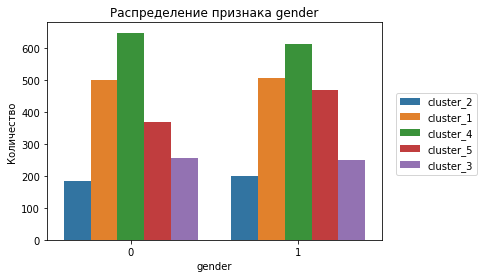

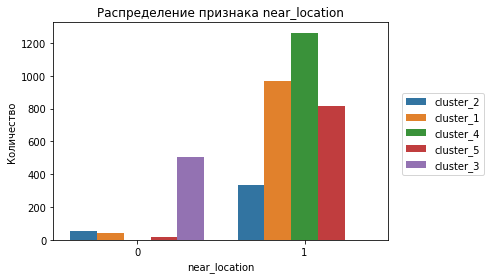

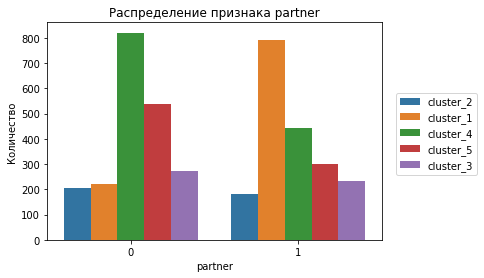

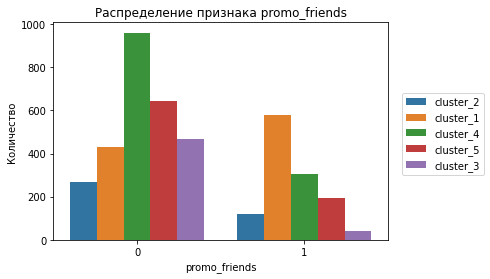

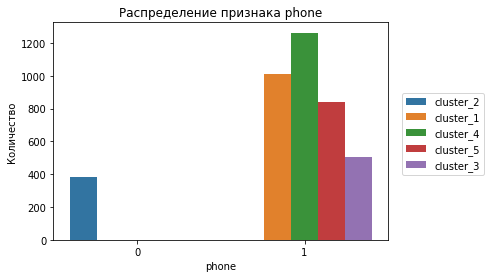

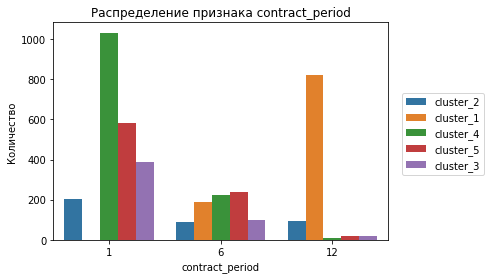

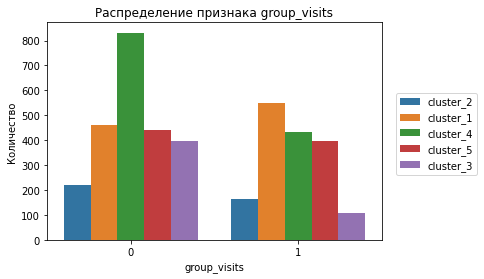

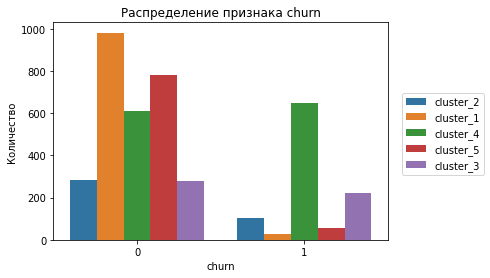

In [27]:
# Построим столбчатые диаграммы

cols = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits', 'churn']
fig, ax = plt.subplots()
for column in cols:
    plt.title("Распределение признака "+column)
    sns.countplot(data=data, x=column, hue='cluster_km')
    plt.xlabel(column)
    plt.ylabel("Количество")
    plt.legend(bbox_to_anchor=(1.3, 0.7))
    plt.show()

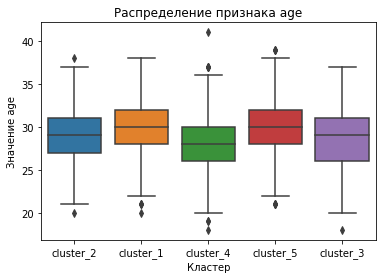

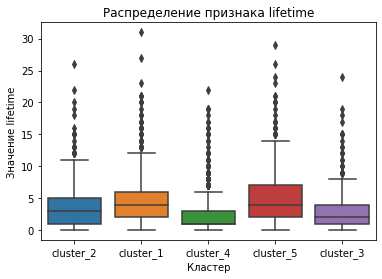

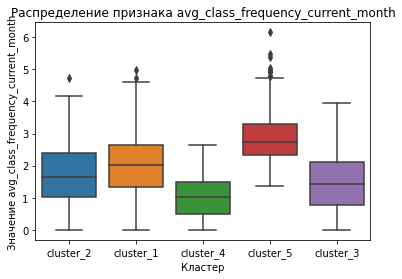

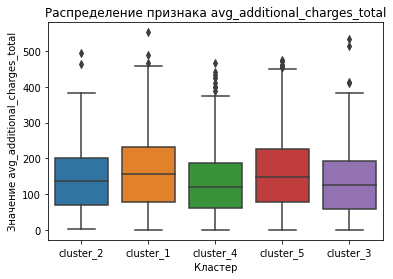

In [28]:
# Построим боксплоты

cols = ['age', 'lifetime', 'avg_class_frequency_current_month', 'avg_additional_charges_total']
fig, ax = plt.subplots()
for column in cols:
    plt.title("Распределение признака "+column)
    sns.boxplot(x='cluster_km', y=column, data=data)
    plt.xlabel('Кластер')
    plt.ylabel('Значение '+column)
    plt.show()

**Кластер 1** характеризуется:

- приблизительно равным распределением между мужчинами и женщинами;
- клиентами, большинство из которых находятся поблизости от фитнес-центра;
- клиентами, большинство из которых пришли от компаний-партнёров;
- клиентами, из которых чуть большая часть пришла по промо-акции от друзей;
- наличием контактных данных;
- абонементом на 6 и 12 месяцев со значительным преобладанием абонементов на 12 месяцев;
- клиентами, чуть большая часть которых посещает групповые занятия;
- средним возрастом около 30 лет;
- большим сроком от начала пользования услугами;
- посещением около 2 раза в неделю;
- самым высоким уровнем дополнительных оплат;


**Кластер 2** характеризуется:

- приблизительно равным распределением между мужчинами и женщинами;
- клиентами, большинство из которых находятся поблизости от фитнес-центра;
- клиентами, среди которых от компаний-партнеров пришло столько же, сколько и не от них;
- клиентами, из которых чуть большая часть пришла не по промо-акции от друзей;
- отсутствием контактных данных;
- абонементом на 1, 6 и 12 месяцев с примерно равным распределением и небольшим преобладанием на 1 месяц;
- клиентами, среди которых чуть меньшая часть посещает групповые занятия;
- средним возрастом около 28,5 лет;
- средним сроком от начала пользования услугами;
- посещением около 1-2 раз в неделю;
- средним уровнем дополнительных оплат;


**Кластер 3** характеризуется:

- приблизительно равным распределением между мужчинами и женщинами;
- клиентами, которые находятся вдали от фитнес-центра;
- клиентами, чуть большая часть которых пришла не от компаний-партнеров;
- клиентами, из которых большая часть пришла не по промо-акции от друзей;
- наличием контактных данных;
- абонементом на 1, 6 и 12 месяцев с большим преобладанием на 1 месяц;
- клиентами, заметно большая часть которых не посещает групповые занятия;
- средним возрастом в 27,5-28 лет;
- небольшим сроком от начала пользования услугами;
- посещением около 1-2 раз в неделю;
- низким уровнем дополнительных оплат;


**Кластер 4** характеризуется:

- чуть большим числом людей одного пола, по сравнению с другим;
- клиентами, которые живут или работают вблизи фитнес-центра;
- клиентами, средт которых пришедших не от компаний-партнеров в 2 раза больше, чем остальных;
- клиентами, из которых большая часть пришла не по промо-акции от друзей;
- наличием контактных данных;
- абонементом на 1, 6 и 12 месяцев с очень большим преобладанием на 1 месяц;
- клиентами, заметно большая часть которых не посещает групповые занятия;
- средним возрастом около 27 лет;
- низким сроком от начала пользования услугами;
- посещением около 1 раз в неделю;
- низким уровнем дополнительных оплат;


**Кластер 5** характеризуется:

- чуть большим числом людей одного пола, по сравнению с другим;
- клиентами, почти все из которых находятся вблизи фитнес-центра;
- клиентами, большинство из которых (около 65%) пришли не от компаний-партнёров;
- клиентами, из которых чуть большая часть пришла не по промо-акции от друзей;
- наличием контактных данных;
- абонементом на 1, 6 и 12 месяцев с преобладанием на 1 месяц;
- клиентами, около половины которых посещает групповые занятия;
- средним возрастом около 28,5 лет;
- очень большим сроком от начала пользования услугами;
- посещением около 2,5 раз в неделю;
- высоким уровнем дополнительных оплат;

### Расчет доли оттока для каждого кластера

In [29]:
display(data
     .groupby('cluster_km')['churn']
     .mean()
     .reset_index()
     .sort_values(by='churn', ascending=False)
     .reset_index(drop=True))

,cluster_km,churn
0,cluster_4,0.514263
1,cluster_3,0.443564
2,cluster_2,0.267532
3,cluster_5,0.068019
4,cluster_1,0.027723


Четвертый кластер больше всего склонен к оттоку: доля составляет около 51-52%. Третий кластер характеризуется долей оттока в 44%, а второй - около 27%. Пятый и первый кластеры (доля оттока 7% и 3%, соответственно) являются самыми надёжными.

## Общий вывод

Анализ данных о клиентах фитнес-центра «Культурист-датасаентист» позволил сделать следующие основные выводы:

1. Среднее по оттоку клиентов близко к 0,3, а медиана равна 0.

Соответственно, **около трети клиентов фитнес-центра уходит в отток**.

2. Среднее по полу клиентов близка к 0,5, а медиана равна 1.

Следовательно, **услугами фитнес-центра пользуются в равной степени мужчины и женщины**.

3. Среднее по близости к фитнес-центру близко к 0,85, а первый квартиль равен 1.Распределения по признаку не сильно отличаются. Среднее значение для лояльных клиентов чуть выше, чем для людей, уходящих в отток.

Таким образом, **фитнес-центр посещает больше клиентов, которые живут поблизости**. При этом немного лояльнее к фитнес-центру те, кто живёт поблизости, чем те, кто живёт в отдалении.

4. Среднее по принадлежности к компании-партнёру близко к 0,5. Распределения для ушедших в отток и оставшихся клиентов ведут себя по-разному.

Получается, в фитнес-центре в равной степени представлены клиенты, являющиеся сотрудниками компаний-партнёров, и люди, не имеющие к ним отношения. Но **ушедшие в отток клиенты в большей степени не являются сотрудниками компаний-партнёров**.

5. Среднее по пришедшим по промо-акции "Приведи друга" равно 0,3, медиана равна 0. Распределения для ушедших в отток и лояльных клиентов близки, но средние значения немного отличаются (для второй группы значение выше).

Соответственно, **большинство клиентов фитнес-центра не пришло по промо-акции "Приведи друга", но среди лояльных клиентов воспользовавшихся акцией больше, чем среди уходящих в отток**.

6. Минимальное значение возраста равно 18, максимальное - 41, среднее - 29. Среднее значение близко к медиане, стандартное отклонение очень низкое, распределение для лояльных и нелояльных клиентов нормальное.

Соответственно, услугами фитнес-центра пользуются клиенты возрастом от 18 до 41 года (со средним возрастом около 29 лет). Причём **в отток в дальнейшем уходят клиенты более молодого возраста (около 27 лет)**.

7. Минимальное значение времени с первого обращения равно 0, максимальное - 31, среднее - 3, медиана близка к 4 месяцам. Распределение времени с момента первого обращения для обоих групп (лояльных и нелояльных) похоже на распределение Пуассона. Но для ушедших в отток клиентов оно сильно смещено влево (со средним в 1 месяц), практически не имея значения в более высоких значениях, а для лояльных клиентов принимает более высокие значения (со средним в 5 месяцев).

Таким образом, в фитнес центре есть "новенькие" клиенты (которые несколько месяцев пользуются услугами центра) и "опытные" клиенты (которые достаточно давно начали посещать фитнес-центр). При этом клиенты, **уже в первые несколько месяцев проявляющие  лояльность к фитнес-центру, скорее всего, не уйдут в отток в последующие месяцы**.

8. Показатель длительности абонемента может принимать значения 1, 6 и 12 месяцев. Среднее значение равно 4-5 месяцев. При этом есть перекос в данных: медиана равна 1 месяцу. Среднее значение для лояльных пользователей - 5-6 месяцев, для уходящих в отток - 1-2 месяца. Показатель времени до окончания абонемента принимает значения от 1 до 12 месяцев. Среднее значение равно 4 месяца, При этом есть перекос в данных: медиана равна 1 месяцу. Различия в распределении групп (лояльных и нелояльных клиентов) по сроку до окончания действующего абонемента такие же, как и в распределениях по длительности абонемента.

Соответственно, **клиенты предпочитают покупать абонемент на короткий срок, но купившие более длительный абонемент с большей неохотой уйдут в отток, чем те, у кого он действует короткий срок**.

9. Среднее по посещаемости групповых занятий близко к 0,4, а медиана равна 0. Распределения по лояльным и уходящим в отток клиентам различаются.

Так, среди клиентов фитнес-центра больше тех, кто не интересуется групповыми занятиями (около 60%). При этом **уходящие в отток клиенты практически не заинтересованы в групповых занятиях**.

10. Средняя частота посещений за всё время с начала действия абонемента и за предыдущий месяц колеблются в промежутке от 0 до 6 раз в неделю. Среднее значение и медиана практически равны, стандартное отклонение невысоко. Распределение для лояльных и нелояльных групп является нормальным. Для лояльной группы оно немного смещено влево (среднее 1-2), а для группы уходящих в отток имеется сильное смещение влево (среднее около 2).

Соответственно, в фитнес-центре есть люди, которые купили абонемент, но ни разу не посетили центр, а есть и очень "приверженные" клиенты (посещение 6 раз в неделю). При этом, в среднем, **все клиенты посещают центр около 1-2 раз в неделю**. Однако, среди лояльных клиентов много тех, кто часто посещает фитнес-центр.

11. Основные метрики полученных моделей, построенных алгоритмом логистической регрессии и алгоритмом случайного леса, следующие: для модели логистической регрессии: Accuracy = 0,94; Precision = 0,90; Recall = 0,85; Для модели случайного леса: Accuracy = 0,92; Precision = 0,88; Recall = 0,83.

Таким образом, и модель логистической регрессии, и модель случайного леса достаточно хорошо способны делать прогноз. Однако, **модель логистической регрессии для используемых данных подходит больше по всем показателям**: доле правильных ответов (accuracy), точности (precision), полноте (recall).

12. По дендрограмме было высказано предположение о наличии четырёх кластеров в данных. Однако, было принято решение для прогноза кластеров клиентов использовать пять кластеров в модели K-Means (четвёртый кластер был заметно больше остальных).


13. Расчет доли оттока для каждого кластера показал, что **наименее лояльным является четвёртый кластер, а наименьшая доля оттока клиентов в первом и пятом кластерах**.

### Рекомендации

1. Рекомендуется отменить проведение акции "Приведи друга" и акций для сотрудников компаний-партнёров - поскольку они не способствуют удержанию клиентов, а вырученные с этого деньги направить на другие мероприятия (например, рекламу в близлежащих спальных районах).


2. Стоит проработать абонементы более длительного срока (6 и 12 месяцев) - поскольку чем дольше времени до окончания абонемента, тем больше лоялен клиент. Также стоит подумать о снижении их стоимости.


3. Возможно ввести более выгодное продление абонемента для клиентов. Например, по окончании абонемента покупка нового с тем же сроком - со скидкой. Подобные скидки окупятся доп. услугами, которыми пользуются лояльные клиенты.


4.  Рекомендуется проводить мониторинг средней частоты посещений фитнес-центра в неделю по клиентам. При обнаружении снижения показателя предлагать клиентам "бонусы" (бесплатная разовая доп. услуга, скидки на продление абонемента, одно бесплатное групповое занятие по новому для него направлению и т.п.).